## ДЗ №2. Матричные факторизации

#### В этой домашке вам предстоит реализовать некоторые базовые модели матричной факторизации

#### Дата выдачи: 17.02.25

#### Мягкий дедлайн: 02.03.25 23:59 MSK

#### Жесткий дедлайн: 09.03.25 23:59 MSK

В этом задании мы будем работать с классическим для рекоендательных систем датасетом [MovieLens 1M](https://grouplens.org/datasets/movielens/1m/). Датасет содержит рейтинги оценки для 4000 фильмов от 6000 пользователей. Более подробное описание можете найти на странице с датасетом и в README файле

In [159]:
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip
!cat ml-1m/README

--2025-03-02 12:18:04--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip.1’

ml-1m.zip.1         100%[===================>]   5.64M  3.83MB/s    in 1.5s    

2025-03-02 12:18:07 (3.83 MB/s) - ‘ml-1m.zip.1’ saved [5917549/5917549]

Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/ratings.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/README? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ml-1m/users.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of

In [160]:
!pip install implicit optuna -q

In [161]:
import pandas as pd
import numpy as np
from typing import Union
import matplotlib.pyplot as plt
import time
import optuna
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, coo_array, csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from implicit.als import AlternatingLeastSquares

In [162]:
df = pd.read_csv("ml-1m/ratings.dat", sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python')
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df.drop('timestamp', axis=1, inplace=True)
df.head()

,user_id,item_id,rating,datetime
0,1,1193,5,2000-12-31 22:12:40
1,1,661,3,2000-12-31 22:35:09
2,1,914,3,2000-12-31 22:32:48
3,1,3408,4,2000-12-31 22:04:35
4,1,2355,5,2001-01-06 23:38:11


In [163]:
value_counts = df['item_id'].value_counts()
filtered_values = value_counts[value_counts > 20].index
df = df[df['item_id'].isin(filtered_values)].copy()

In [164]:
train_end = '2000-12-01'
df_train = df[df['datetime'] < train_end].copy()
df_test = df[df['datetime'] >= train_end].copy()
df_train.shape, df_test.shape

((787420, 4), (207432, 4))

In [165]:
train_users = df_train['user_id'].unique()
train_items = df_train['item_id'].unique()

df_test = df_test[df_test['user_id'].isin(train_users)]
df_test = df_test[df_test['item_id'].isin(train_items)]
df_test.shape

(106471, 4)

In [166]:
user_le = LabelEncoder()
item_le = LabelEncoder()

df_train['user_id'] = user_le.fit_transform(df_train['user_id'])
df_train['item_id'] = item_le.fit_transform(df_train['item_id'])

df_test['user_id'] = user_le.transform(df_test['user_id'])
df_test['item_id'] = item_le.transform(df_test['item_id'])

In [167]:
df_train['user_id'].nunique(), df_train['user_id'].max()

(5365, 5364)

In [168]:
df_train['item_id'].nunique(), df_train['item_id'].max()

(3010, 3009)

##### Задание 1. Напишем функцию, которая превратит датафрейм в матрицу интеракций. В функции df_to_matrix реализуйте функцию, которая принимает датафрейм и возвращает np.array матрицу интеракций. В функции df_to_coo реализуйте функцию, которая принимает датафрейм и возвращает разреженную матрицу интеракций в coo_array формате

In [169]:
def df_to_matrix(df: pd.DataFrame) -> np.ndarray:
    interaction_df_to_matrix = df_train.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    result = interaction_df_to_matrix.values
    return result

In [170]:
interactions = df_to_matrix(df_train)

In [171]:
# проверим размер матрицы
assert interactions.shape[0] == 5365
assert interactions.shape[1] == 3010

In [34]:
interactions[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [172]:
def df_to_coo(df: pd.DataFrame) -> coo_array:
    interaction_df_to_matrix = df_train.pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)
    matrix_values = interaction_df_to_matrix.values
    nonzero_row_indices, nonzero_col_indices = np.nonzero(matrix_values)
    values = matrix_values[nonzero_row_indices, nonzero_col_indices]
    result = coo_array((values, (nonzero_row_indices, nonzero_col_indices)), shape=matrix_values.shape)

    return result

In [173]:
coo_interactions = df_to_coo(df_train)

In [174]:
#Матрица
coo_interactions.toarray()[:10, :10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [5., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [175]:
assert (interactions != 0).sum() == df_train.shape[0]
assert interactions[0, 2994] == 3
assert interactions[2369, 1203] == 5
assert interactions[1557, 459] == 3
assert np.allclose(coo_interactions.toarray(), interactions)

##### Задание 2.1. Рассмотрим [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition). Возьмите готовую реализуцию алгоритма из numpy.linalg или из scipy.linalg и примените алгоритм к матрицам интеракций, полученным в первом задании. Для работы со sparse матрицей обычная реализация svd не подойдет и нужно будет воспользоваться scipy.sparse.linalg.svds. Вам нужно разложить матрицу интеракций на 3 матрицы U, S, V, а затем перемножить их и восстановить изначальную матрицу. При полном разложении исходная матрица должна восстанавливаться максимально хорошо

In [176]:
def make_svd(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1):
    # функция должна работать и для полной матрицы и для sparse матрицы(вам поможет isinstance).
    # если n_singular_values = -1, то берем все сингулярные числа для полной матрицы
    # и все кроме одного сингулярного числа для coo-матрицы(иначе scipy.sparse.linalg.svds не будет работать)

    #your code here
    if isinstance(interractions, np.ndarray):  #Если матрица является полной (np.ndarray), то выполняется SVD с помощью функции np.linalg.svd
        U, S, V = np.linalg.svd(interractions, full_matrices=False) #U, S, и V — матрицы, полученные в результате SVD. Параметр full_matrices=False означает, что возвращаются только уменьшенные матрицы
        if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]
    elif isinstance(interractions, coo_array):  #SVD для разреженной матрицы
        if n_singular_values == -1:
            n_singular_values = interractions.shape[1] - 1
        U, S, V = svds(interractions, k=n_singular_values)
    if n_singular_values != -1:
            U = U[:, :n_singular_values]
            S = S[:n_singular_values]
            V = V[:n_singular_values, :]

    return U, S, V

In [177]:
U, S, V = make_svd(interactions)
assert np.allclose(U @ np.diag(S) @ V, interactions)

In [178]:
U1, S1, V1 = make_svd(interactions, 10)
U, S, V = make_svd(coo_interactions, 10)
assert np.allclose(U1 @ np.diag(S1) @ V1, U @ np.diag(S) @ V)

##### Задание 2.2. Теперь попробуем сделать рекомендации с помощью SVD. Мы научились восстанавливать исходную матрицу с помощью разложения, теперь же мы хотим порекомендовать пользователю айтемы, которые будут для него максимально релевантны(в восстановленной матрице у них будет самый высокий скор). Для каждого пользователя нужно будет найти индексы айтемов, которые имеют максимальный скор. При этом стоит обратить внимание, что мы не хотим рекомендовать пользователю айтемы, с которыми он уже взаимодействовал

In [182]:
def make_svd_recommendations(interractions: Union[np.ndarray, coo_array], n_singular_values: int = -1, top_k: int = 100):
    # Возвращает матрицу вида n_users, top_k, то есть для каждого пользователя возвращаем индексы
    # top_k самых релевантный айтемов среди тех с которыми он еще не взаимодействовал
    #your code here
    U, S, V = make_svd(interractions, n_singular_values)
    matrix_multiplication_U_S_V_predict = np.dot(np.dot(U, np.diag(S)), V)  #предсказанные рейтинги вычисляются путем умножения матриц U, S (превращенной в диагональную матрицу) и V. Это позволяет восстановить полную матрицу рейтингов на основе уменьшенного пространства
    n_users, n_items = matrix_multiplication_U_S_V_predict.shape
    recommendations = np.zeros((n_users, top_k), dtype=int)
    for user in range(n_users):
        search_items_interacted = np.where(interractions[user] > 0)[0]
        user_ratings = matrix_multiplication_U_S_V_predict[user]
        user_ratings[search_items_interacted] = -np.inf
        top_k_i = np.argsort(user_ratings)[-top_k:][::-1]
        recommendations[user] = top_k_i
    return recommendations #shape ~ [n_users, top_k]

In [183]:
recs = make_svd_recommendations(interactions, -1, 100)
assert recs.shape == (interactions.shape[0], 100)

##### Задание 2.3. Теперь давайте посмотрим как будет зависеть качетво рекомендаций, от количества сингулярных чисел, которые мы возьмем в SVD разложении. Переберите n_singular_values из списка [1, 10, 50, 200, 1000] и посмотрите как будет изменяться метрика NDCG на тестовом датасете для таких рекомендаций и как будет меняться время вычисления. Для каждого графики зависимости метрики NDCG от n_singular_values и времени работы алгоритма от n_singular_values(Время работы будет меняться только для sparse-матрицы, стоит запускать алгоритм именно для нее)

In [184]:
def discounted_cumulative_gain(scores) :  #Эта функция вычисляет Discounted Cumulative Gain (DCG), который используется для оценки качества ранжирования рекомендаций.
    return np.sum(np.divide(np.power(2, scores) - 1,
                            np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64) #Вычисляем логарифм позиции элемента (начиная с 2, чтобы избежать деления на ноль).


In [185]:

def discounted_cumulative_gain_metric(gt_items, predicted):  # Эта функция вычисляет Normalized Discounted Cumulative Gain (NDCG), который нормализует DCG идеальным DCG (IDCG) для того же набора данных. Это позволяет сравнивать результаты на разных наборах данных.
    number_elements = len(predicted)    # определяем количество элементов, которые следует учитывать при вычислении идеального DCG
    array_elements_1_0 = np.array([1 if x in predicted else 0 for x in gt_items]) # массив, где каждый элемент равен 1, если соответствующий элемент из gt_items
    calculat_discounted_cumulative_gain = discounted_cumulative_gain(array_elements_1_0) # вычисляем DCG для предсказанных элементов
    if calculat_discounted_cumulative_gain == 0.0:
        return 0.0
# IDCG имеет все значения, равные 1 (или указанным значениям), вплоть до количества элементов в тестовом наборе, которое может поместиться в длину списка
    ideal_discounted_cumulative_gain = discounted_cumulative_gain(np.sort(array_elements_1_0)[::-1][:number_elements])
    if ideal_discounted_cumulative_gain == 0.0:
        return 0.0
    ndcg_ = calculat_discounted_cumulative_gain / ideal_discounted_cumulative_gain
    return ndcg_



In [186]:
def quality_recsys (df, gt_col="test_interactions", predict_col='recs', topn=10): # функция предназначена для оценки качества рекомендательной системы
    metric_items_pred = []
    for idx, row in df.iterrows():  #перебираем каждую строку в DataFrame.
        gt_items = row[gt_col]
        predict_recom = row[predict_col]
        metric_items_pred.append((discounted_cumulative_gain_metric(gt_items, predict_recom)))
    return {"ndcg": np.mean(metric_items_pred)}

In [187]:
range_user_ids = range(len(recs))   #создаётся диапазон целых чисел, который будет использоваться в качестве идентификаторов пользователей
new_df_colum_recs_user = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user['recs'] = [list(row) for row in recs]
new_df_colum_recs_user.head()

,user_id,recs
0,0,"[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ..."
1,1,"[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224..."
2,2,"[1, 17, 299, 10, 499, 942, 12, 242, 1307, 449,..."
3,3,"[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ..."
4,4,"[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278..."


In [188]:
# создаем тестовый df с user_id и test_interactions.
test_new_df_colum_user_item = df_test.groupby('user_id').apply(lambda x: list(x['item_id']), include_groups=False).reset_index(name='test_interactions')
test_new_df_colum_user_item.head()

,user_id,test_interactions
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]"
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]"
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4..."


In [189]:
# предудыщему test_new_df_colum_user_item добавим recs

result_df = test_new_df_colum_user_item.merge(new_df_colum_recs_user[['user_id', 'recs']], on='user_id', how='left')
result_df.head()

,user_id,test_interactions,recs
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[1, 5, 2, 14, 20, 7, 12, 22, 28, 4, 27, 1542, ..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[5, 32, 18, 19, 1046, 29, 31, 30, 20, 878, 224..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[10, 5, 1, 9, 23, 1610, 2241, 2237, 2607, 15, ..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[4, 2374, 28, 873, 215, 6, 24, 299, 1738, 2278..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[6, 7, 2168, 2029, 2045, 2579, 725, 2278, 12, ..."


In [190]:

quality_recsys(result_df)
print (quality_recsys(result_df))

{'ndcg': 0.3357219306722853}


In [202]:
#Данный код предназначен для построения графика, отражающего зависимость времени выполнения
#и метрики NDCG (Normalized Discounted Cumulative Gain) от количества сингулярных значений, используемых в методе SVD
def plot_graphs(interractions: Union[np.ndarray, coo_array], test_new_df_colum_user_item, top_k: int = 100):
    #your code here
        #словари для хранения времени выполнения и значения NDCG соответственно
    save_time = {}
    ndcg = {}
    for n_singular_values in tqdm([1, 10, 50, 200, 1000], desc="Прогноз и расчет метрик"):
       #your code here
        time_start = time.time()
        recs = make_svd_recommendations(interactions, n_singular_values, 100)
        time_end = time.time()
        count_time = time_end - time_start
        save_time[n_singular_values] = count_time
        range_user_ids = range(len(recs))
        new_df_colum_recs_user = pd.DataFrame({'user_id': range_user_ids})
        new_df_colum_recs_user[f'recs_{n_singular_values}'] = [list(row) for row in recs]
        result_df = test_new_df_colum_user_item.merge(
            new_df_colum_recs_user[['user_id', f'recs_{n_singular_values}']],
            on='user_id',
            how='left')
        ndcg[n_singular_values] = quality_recsys(result_df, predict_col=f'recs_{n_singular_values}').get('ndcg')
    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Количество сингулярных значений')
    ax1.set_ylabel('Время выполнения (с)', color='tab:blue')
    ax1.plot(save_time.keys(), save_time.values(), color='tab:blue', marker='o', label='Время выполнения')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('NDCG', color='tab:red')
    ax2.plot(ndcg.keys(), ndcg.values(), color='tab:red', marker='x', label='NDCG')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Время выполнения и NDCG в зависимости от количества сингулярных значений')
    fig.tight_layout()
    plt.show()

Прогноз и расчет метрик:   0%|          | 0/5 [00:00<?, ?it/s]

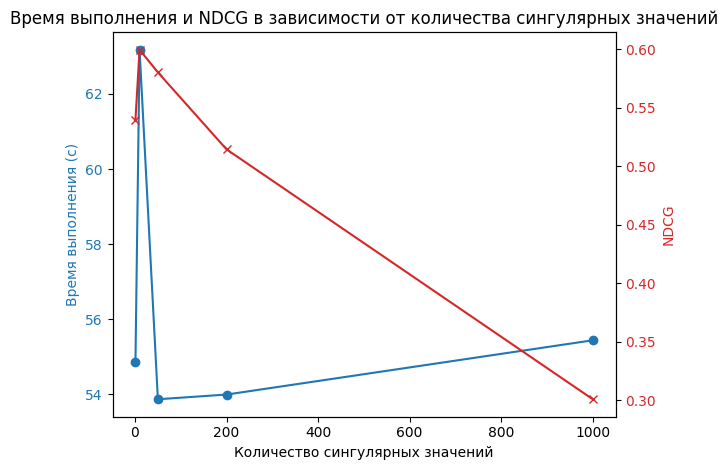

In [201]:
plot_graphs(interractions=coo_interactions,
            test_new_df_colum_user_item=test_new_df_colum_user_item)

Что нам демонстрирует график? ГРафик показывает, что :
- при увеличении значений так же увеличивается время выполнения задачи. Прямая корреляция.
- Падение NDCG при росте сингулярных значений, связано:
-- Переобучением или чрезмерным уменьшением размерности. Если при росте сингулярных значений модель начинает слишком сильно фокусироваться на нескольких доминирующих признаках, это может привести к ухудшению качества ранжирования, поскольку другие важные признаки игнорируются.
-- Утрата важной информации: Если сингулярные значения отражают важные признаки данных, но при росте этих значений модель начинает игнорировать менее важные признаки, это может привести к потере информации.
-- Неправильная интерпретация данных: Возможно, что рост сингулярных значений не соответствует ожидаемому улучшению качества ранжирования из-за неправильной интерпретации данных или ошибок в модели.

##### Задание 3.1. Перейдем к [ALS](http://yifanhu.net/PUB/cf.pdf). Возьмем реализацию iALS из библиотеки [implicit](https://benfred.github.io/implicit/api/models/cpu/als.html). Обучите ALS на нашем датасете, сделайте top_k рекомендации для юзеров из тестового датасета, и сравните метрики ALS с метриками, которые получились в SVD. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов, коэффициент alpha и коэффициент регуляризации.

In [203]:
#рекомендательная систему на основе алгоритма Alternating Least Squares (ALS).
def make_als_recommendations(
    interactions: np.ndarray,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
#your code here

    range_user_ids, item_ids = interactions.nonzero() #получаем индексы пользователей и предметов, где есть взаимодействия, и соответствующие им оценки.
    us_ratings = interactions[range_user_ids, item_ids]
    coo_interactions = coo_matrix((us_ratings, (range_user_ids, item_ids)), shape=interactions.shape)
    csr_interactions = coo_interactions.tocsr() #CSR удобен для операций над разреженными матрицами
    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    model.fit(csr_interactions)
    scores = model.recommend_all(csr_interactions, N=top_k)
    return scores

In [204]:
recs = make_als_recommendations(interactions=interactions)
assert recs.shape == (coo_interactions.shape[0], 100)

  0%|          | 0/15 [00:00<?, ?it/s]

In [207]:
range_user_ids = range(len(recs))
new_df_colum_recs_user_als = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user_als['recs_als'] = [list(row) for row in recs]
new_df_colum_recs_user_als.head()
result_df_als = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als[['user_id', 'recs_als']], on='user_id', how='left')
result_df_als.head()

,user_id,test_interactions,recs_als
0,0,"[925, 926, 2992, 927, 936, 3004, 959, 670, 124...","[670, 944, 665, 580, 684, 262, 924, 499, 1417,..."
1,1,"[927, 928, 929, 933, 2278, 496, 2279, 2284, 30...","[929, 944, 887, 2278, 685, 898, 95, 908, 904, ..."
2,3,"[925, 2995, 961, 1848, 839, 2780, 2399, 891]","[95, 432, 253, 16, 955, 254, 1617, 2699, 3009,..."
3,4,"[580, 665, 666, 1203, 510, 2097, 775, 47]","[877, 2630, 878, 2806, 681, 1038, 820, 1142, 4..."
4,6,"[1520, 2886, 1521, 934, 569, 2278, 935, 936, 4...","[1982, 875, 496, 1940, 877, 1167, 889, 2055, 2..."


In [208]:
quality_recsys(result_df_als, predict_col='recs_als')

{'ndcg': 0.5550435161780827}

Метод ALS демонстрирует относительно высокое качество ранжирования. Чем ближе значение NDCG к 1, тем лучше система ранжирует релевантные элементы. Значение 0.555 указывает на то, что система неплохо справляется с ранжированием, но есть место для улучшения.
{'ndcg': 0.3357219306722853} - метод SVD показывает меньший реультат.

In [212]:
# Задача. Попробуйте перебрать гиперпараметры и найдите оптимальное число факторов,
# коэффициент alpha и коэффициент регуляризации.подбор гиперпараметров

# Этот код использует библиотеку Optuna для оптимизации гиперпараметров модели рекомендаций,
# основанной на Alternating Least Squares (ALS)
def hyperparameter_optimization_process(trial):
    n_factors = trial.suggest_categorical('n_factors', [10, 20, 50, 100])
    alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
    regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)
#генерирует рекомендации с помощью функции make_als_recommendations,
# которая принимает матрицу взаимодействий (interactions),
# количество факторов (n_factors), параметр альфа (alpha),
# регуляризацию (regularization) и возвращает рекомендации для каждого пользователя.
    generating_rec = make_als_recommendations(interactions, top_k=100, n_factors=n_factors, alpha=alpha, regularization=regularization)
    range_user_ids = range(len(recs))
    new_df_colum_recs_user_als = pd.DataFrame({'user_id': range_user_ids})
    new_df_colum_recs_user_als['recs_als'] = [list(row) for row in generating_rec]
    new_df_colum_recs_user_als.head()
    result_df_als = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als[['user_id', 'recs_als']], on='user_id', how='left')
    quality_recom = quality_recsys(result_df_als, predict_col='recs_als').get('ndcg')
    return quality_recom  #возвращает значение метрики NDCG, которое будет использовано для оптимизации.
optimization_max = optuna.create_study(direction='maximize')
optimization_max.optimize(hyperparameter_optimization_process, n_trials=20)  #Создаётся объект с направлением оптимизации на максимизацию (в данном случае метрики NDCG).

[I 2025-03-02 13:37:46,810] A new study created in memory with name: no-name-37b59aa8-eb2c-4ea5-b0ae-bce4c316248f
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:38:08,811] Trial 0 finished with value: 0.5979069892292185 and parameters: {'n_factors': 10, 'alpha': 0.4402241622687038, 'regularization': 0.33042938176878445}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:38:35,161] Trial 1 finished with value: 0.5887296775944695 and parameters: {'n_factors': 20, 'alpha': 0.6765442950785227, 'regularization': 0.07665069873159298}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:39:01,745] Trial 2 finished with value: 0.548532638689205 and parameters: {'n_factors': 100, 'alpha': 1.7424961561627785, 'regularization': 0.011400372433908576}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:39:30,918] Trial 3 finished with value: 0.5770025404752671 and parameters: {'n_factors': 50, 'alpha': 0.5649004082518108, 'regularization': 0.0983175703620791}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:39:52,818] Trial 4 finished with value: 0.591687455892703 and parameters: {'n_factors': 10, 'alpha': 0.1195864311745732, 'regularization': 0.046524255476221715}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:40:20,134] Trial 5 finished with value: 0.5564925024005378 and parameters: {'n_factors': 100, 'alpha': 0.17232767675034427, 'regularization': 0.055990511468361696}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:40:43,073] Trial 6 finished with value: 0.596931127303103 and parameters: {'n_factors': 10, 'alpha': 0.5048611220578479, 'regularization': 0.014163848921821105}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:41:06,049] Trial 7 finished with value: 0.5927915146153507 and parameters: {'n_factors': 10, 'alpha': 0.20989505657067847, 'regularization': 0.6845788038688078}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:41:32,307] Trial 8 finished with value: 0.5564368335733078 and parameters: {'n_factors': 100, 'alpha': 0.24032607413176943, 'regularization': 0.017223524547891236}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:41:55,200] Trial 9 finished with value: 0.5972798899067044 and parameters: {'n_factors': 10, 'alpha': 1.5936750966207633, 'regularization': 0.039625581579856475}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:42:22,805] Trial 10 finished with value: 0.5742294732919401 and parameters: {'n_factors': 50, 'alpha': 0.9462815277949508, 'regularization': 0.4841054768376853}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:42:45,757] Trial 11 finished with value: 0.5937359360577323 and parameters: {'n_factors': 10, 'alpha': 1.6287696922238974, 'regularization': 0.2596431487453818}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:43:07,420] Trial 12 finished with value: 0.5957520467611318 and parameters: {'n_factors': 10, 'alpha': 0.299530030781923, 'regularization': 0.24081960297422866}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:43:33,621] Trial 13 finished with value: 0.5900957973110204 and parameters: {'n_factors': 20, 'alpha': 1.0664640585385838, 'regularization': 0.21718908875380535}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:43:56,408] Trial 14 finished with value: 0.5945830234581255 and parameters: {'n_factors': 10, 'alpha': 0.3753662740804037, 'regularization': 0.028606932883760063}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:44:19,087] Trial 15 finished with value: 0.595632545064325 and parameters: {'n_factors': 10, 'alpha': 0.8562770744485327, 'regularization': 0.9928296291575857}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:44:42,006] Trial 16 finished with value: 0.5952449743427756 and parameters: {'n_factors': 10, 'alpha': 1.3328457503487268, 'regularization': 0.15497617131704775}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:45:09,430] Trial 17 finished with value: 0.5740741396892189 and parameters: {'n_factors': 50, 'alpha': 0.3821379601456794, 'regularization': 0.02635707477012024}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:45:35,513] Trial 18 finished with value: 0.5877267809756445 and parameters: {'n_factors': 20, 'alpha': 0.725040876476642, 'regularization': 0.4329778447237317}. Best is trial 0 with value: 0.5979069892292185.
<ipython-input-212-9d8273f1a002>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  alpha = trial.suggest_loguniform('alpha', 0.1, 2.0)
<ipython-input-212-9d8273f1a002>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  regularization = trial.suggest_loguniform('regularization', 0.01, 1.0)


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-03-02 13:45:58,526] Trial 19 finished with value: 0.6003660625264181 and parameters: {'n_factors': 10, 'alpha': 1.226074261334473, 'regularization': 0.1439148068518943}. Best is trial 19 with value: 0.6003660625264181.


In [213]:
print("Лучшие параметры :", optimization_max.best_params)
print("Лучший optimization_max :", optimization_max.best_value)

Лучшие параметры : {'n_factors': 10, 'alpha': 1.226074261334473, 'regularization': 0.1439148068518943}
Лучший optimization_max : 0.6003660625264181


##### Задание 3.2. Сделайте объяснение рекомендаций для нескольких юзеров(als.explain). Воспользуйтесь файлом movies.dat чтобы перейти от индексов фильмов к их названием

In [214]:
# Для выполнения задания возмьем предыдущий метод и изменим его немного.

def make_als_recommendations(
    interactions: np.ndarray,
    top_k: int = 100,
    n_factors: int = 100,
    alpha: float = 1.0,
    regularization: float = 0.01,
):
    range_user_ids, item_ids = interactions.nonzero()
    us_ratings = interactions[range_user_ids, item_ids]
    coo_interactions = coo_matrix((us_ratings, (range_user_ids, item_ids)), shape=interactions.shape)
    csr_interactions = coo_interactions.tocsr()
    model = AlternatingLeastSquares(factors=n_factors, regularization=regularization, alpha=alpha)
    model.fit(csr_interactions)
    scores = model.recommend_all(csr_interactions, N=top_k)
    return scores, model

ПРоведем обучением модли с наилучшими гиперпараметрами

In [218]:
optimization_max_best_params = optimization_max.best_params
best_score, best_model = make_als_recommendations(
    interactions,
    top_k=100,
    n_factors=optimization_max_best_params['n_factors'],
    alpha=optimization_max_best_params['alpha'],
    regularization=optimization_max_best_params['regularization']
)

range_user_ids = range(len(recs))
new_df_colum_recs_user_als = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user_als['recs_als'] = [list(row) for row in best_score]
result_df_als = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als[['user_id', 'recs_als']], on='user_id', how='left')
quality_recsys(result_df_als, predict_col='recs_als')

  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.595085375946241}

In [221]:
import chardet

with open("ml-1m/movies.dat", 'rb') as f:
    result = chardet.detect(f.read())
    print(result)
movies_df = pd.read_csv("ml-1m/movies.dat", sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding=result['encoding'])

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [225]:
movies_df[movies_df.movie_id == 671]

,movie_id,title,genres
665,671,Mystery Science Theater 3000: The Movie (1996),Comedy|Sci-Fi


In [227]:
movies_df[movies_df.movie_id == 672]

,movie_id,title,genres
666,672,Tarantella (1995),Drama


In [230]:
movies_df[movies_df.movie_id == 900]

,movie_id,title,genres
888,900,"American in Paris, An (1951)",Musical|Romance


In [222]:
movies_df.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [239]:
result_df_als['recs_als'].iloc[0][0]

670

In [254]:
result_df_als['recs_als'].iloc[1][0]

638

In [255]:
result_df_als['recs_als'].iloc[2][0]

2211

In [262]:
result_df_als['recs_als'].iloc[3][0]

877

In [257]:
movies_df[movies_df.movie_id == 671]

,movie_id,title,genres
665,671,Mystery Science Theater 3000: The Movie (1996),Comedy|Sci-Fi


In [258]:
movies_df[movies_df.movie_id == 639]

,movie_id,title,genres
634,639,Girl 6 (1996),Comedy


In [246]:
movies_df[movies_df.movie_id == 17]

,movie_id,title,genres
16,17,Sense and Sensibility (1995),Drama|Romance


In [263]:
movies_df[movies_df.movie_id == 878]

,movie_id,title,genres
867,878,Bye-Bye (1995),Drama


1. Посомтрим почему рекомендуюца те или иные фильмы на примере пользователя 1

In [235]:
user_items_1 = csr_matrix(interactions[1, :])
user_id_1 = 0
itemid_1 = 0
best_model.explain(user_id_1, user_items_1, itemid_1)

(0.47250094173922264,
 [(242, 0.03587189357661457),
  (510, 0.03373932530734152),
  (2168, 0.03120459033328776),
  (262, 0.029050323346968058),
  (674, 0.028176541515550196),
  (1497, 0.02629544983004252),
  (449, 0.026119458540156033),
  (499, 0.02580423710482371),
  (47, 0.02465533891432435),
  (1203, 0.024061423930940167)],
 (array([[ 2.67017916e+00, -5.20471631e-01, -3.19179452e-01,
           4.30097520e-01, -3.13923150e-01,  3.87247360e-02,
           9.43402885e-02,  3.80300226e-01, -1.33709717e-01,
          -2.67582425e-01],
         [-1.38975251e+00,  2.68222518e+00,  1.78201472e-03,
          -6.31342623e-01, -1.19082454e-01, -3.96532641e-01,
          -3.80211390e-01, -7.30567203e-01, -3.49740290e-01,
          -2.19863069e-01],
         [-8.52266322e-01,  1.70903615e-01,  2.44189904e+00,
          -1.21348356e-01, -1.73874836e-01, -1.31322676e-01,
          -4.03199569e-01, -2.31207529e-01, -3.22682168e-01,
          -5.89803957e-02],
         [ 1.14843744e+00, -1.91725664

ПОчему был рекомендован фильм Girl 6 (1996)	Comedy

In [247]:
movies_df[movies_df.movie_id == 242]

,movie_id,title,genres
239,242,Farinelli: il castrato (1994),Drama|Musical


In [248]:
movies_df[movies_df.movie_id == 510]

,movie_id,title,genres
506,510,Poetic Justice (1993),Drama


In [251]:
movies_df[movies_df.movie_id == 2168]

,movie_id,title,genres
2099,2168,Dance with Me (1998),Drama|Romance


In [252]:
movies_df[movies_df.movie_id == 262]

,movie_id,title,genres
259,262,"Little Princess, A (1995)",Children's|Drama


In [253]:
movies_df[movies_df.movie_id == 674]

,movie_id,title,genres
668,674,Barbarella (1968),Adventure|Sci-Fi


In [259]:
movies_df[movies_df.movie_id == 1497]

,movie_id,title,genres
1465,1497,Double Team (1997),Action


Анализ показывает что на рекомендацию оказали выборки из фильмов:  
- 	Farinelli: il castrato (1994) - Drama|Musical
- Poetic Justice (1993) - Drama
- Dance with Me (1998) - Drama|Romance
- Little Princess, A (1995) - Children's|Drama

Рекмоендация выглядит немного странной. в основном пользователь смотрел драму 90-х годов. Ему рекомендуется  Girl 6 (1996) из категории Comedy.
Имеется одно пересечение в том, что 90-х годах был выпущен фильм в прокат. в категории Musical возможно это повлияло.


Посмтри другие варианты

In [ ]:
result_df_als['recs_als'].iloc[2][0]

16

In [ ]:
movies_df[movies_df.movie_id == 17]

,movie_id,title,genres
16,17,Sense and Sensibility (1995),Drama|Romance


2. Попробуем понять почему пользователю 3 был порекомендован романтический драматический фильм Bye-Bye (1995)	Drama

In [264]:
result_df_als['recs_als'].iloc[3][0]

877

In [265]:
movies_df[movies_df.movie_id == 878]

,movie_id,title,genres
867,878,Bye-Bye (1995),Drama


In [290]:
user_items_3 = csr_matrix(interactions[3, :])
user_id_3 = 0
itemid_3 = 0
best_model.explain(user_id_3, user_items_3, itemid_3)

(0.3893042365885518,
 [(32, 0.037364433523068306),
  (844, 0.03597109527527676),
  (510, 0.03019436493073118),
  (2168, 0.027778233101811812),
  (799, 0.02727936146942973),
  (94, 0.023376833733435663),
  (1266, 0.022306938616137643),
  (262, 0.019175985425101332),
  (959, 0.019037209422776497),
  (242, 0.018931804600480374)],
 (array([[ 2.96177609, -0.13222424, -0.43196245,  0.60314814, -0.28377556,
           0.17421288, -0.0705964 ,  0.35834477, -0.12073301, -0.54328349],
         [-0.3916186 ,  3.15564157, -0.26203202, -0.48575511,  0.03417308,
          -0.35299764, -0.42960029, -0.68869408, -0.25562412, -0.56817715],
         [-1.27937605, -0.76976322,  2.68733735, -0.16620626, -0.32297741,
          -0.27880325, -0.30755483, -0.47149189, -0.43185171, -0.03585798],
         [ 1.78638974, -1.61261981, -0.57990624,  3.32509522, -0.42994949,
           0.04394303, -0.13766276,  0.40903965, -0.07728382, -0.10745994],
         [-0.84047965,  0.14535999, -0.75432332, -1.56370058,  2.39

In [291]:
movies_df[movies_df.movie_id == 32]

,movie_id,title,genres
31,32,Twelve Monkeys (1995),Drama|Sci-Fi


In [292]:
movies_df[movies_df.movie_id == 844]

,movie_id,title,genres
833,844,"Story of Xinghua, The (1993)",Drama


In [268]:
movies_df[movies_df.movie_id == 2168]

,movie_id,title,genres
2099,2168,Dance with Me (1998),Drama|Romance


In [293]:
movies_df[movies_df.movie_id == 510]

,movie_id,title,genres
506,510,Poetic Justice (1993),Drama


Данная рекомендация имеет больше пересечений с другими фильмами:
1) это по году выпуска 90-е (1995). Рекомендация связана с годом выпуска.
2) рекомендация связана с категорией фильма 	Drama.

Рекомендация фильма имеет близкие категории и год выпуска наиболее релевантна для **пользователя**.


ПРоверим другого пользователя 200

In [284]:
result_df_als['recs_als'].iloc[200][0]

215

In [272]:
movies_df[movies_df.movie_id == 216]

,movie_id,title,genres
214,216,Billy Madison (1995),Comedy


3. Почему пользователю 200 был порекомендован фильм Billy Madison (1995)	Comedy


In [289]:
user_items_3 = csr_matrix(interactions[200, :])
user_id_3 = 0
itemid_3 = 0
best_model.explain(user_id_3, user_items_3, itemid_3)

(0.35891980411747665,
 [(2168, 0.04650341380432723),
  (1137, 0.041192569124456756),
  (1307, 0.037017142754963366),
  (2278, 0.03588354951604513),
  (947, 0.03091873441853027),
  (873, 0.02878567822070833),
  (2119, 0.023133945070861237),
  (2588, 0.023102405598460114),
  (904, 0.02262052217923826),
  (2125, 0.02260330618339704)],
 (array([[ 2.59388508, -0.52327418,  0.03056976,  0.30042772, -0.16228253,
           0.18495783, -0.12366811,  0.12796159, -0.29301426, -0.28089289],
         [-1.3573131 ,  2.69090652, -0.18243551, -0.57788382, -0.17038791,
          -0.50855181, -0.15858167, -0.51631248, -0.18662321, -0.25437098],
         [ 0.07929445, -0.50691328,  2.40074031,  0.13389132, -0.36098355,
          -0.1618227 , -0.31664692, -0.10542157, -0.30818225,  0.04272961],
         [ 0.77927498, -1.71223741,  0.43604883,  2.59619918, -0.31249288,
          -0.15861374, -0.15731464,  0.14982898, -0.18976372,  0.12307365],
         [-0.42094224, -0.37357966, -0.84050391, -0.80991607, 

In [294]:
movies_df[movies_df.movie_id == 2168]

,movie_id,title,genres
2099,2168,Dance with Me (1998),Drama|Romance


In [295]:
movies_df[movies_df.movie_id == 1137]

,movie_id,title,genres
1121,1137,Hustler White (1996),Romance


In [296]:
movies_df[movies_df.movie_id == 1307]

,movie_id,title,genres
1287,1307,When Harry Met Sally... (1989),Comedy|Romance


In [297]:
movies_df[movies_df.movie_id == 2278]

,movie_id,title,genres
2209,2278,Ronin (1998),Action|Crime|Thriller


In [298]:
movies_df[movies_df.movie_id == 947]

,movie_id,title,genres
935,947,My Man Godfrey (1936),Comedy


Пользователю рекомендован комедийный фильм Billy Madison (1995), что коррелирует с просмотренными фильмами. Пересекается по году выпуска и  категории (комедия).

##### Задание 4. До этого мы работали с рейтингами, но как обсуждалось на лекции, implicit ALS отлично работает и с implicit фидбэком. Давайте попробуем преобразовать наш датасет(трейн и тест) следующим образом

1. Бинаризуем все рейтинги(заменим любую интеракцию пользователя на 1)
2. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на 0
3. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1
4. Заменим на 1 только рейтинги 4 и 5, а рейтинг ниже 4 заменим на -1 и добавим сглаживание по времени. То есть чем дальше была интеракция от максимальной даты трейна, тем с меньшим весом мы будем ее учитывать(например можно интеракции за последний месяц брать в исходном виде, и с каждым месяцем в прошлое умножать их на какой-нибудь коэффициент меньший 1). Таким образом более старые интеракции пользователя будут вносить меньший вклад в его интересы
5. Придумайте свой вариант(опционально)

Для каждой полученной матрицы обучите iALS и SVD и сравните их результаты между собой(преобразовывать нужно только обучающую выборку, тестовую оставляем неизменной)

In [308]:
converting_binary_data = np.where(interactions > 0, 1, 0)  #Преобразование взаимодействий в бинарные данные
generating_recom, _ = make_als_recommendations(
    converting_binary_data,
    top_k=100,
    n_factors=optimization_max_best_params['n_factors'],
    alpha=optimization_max_best_params['alpha'],
    regularization=optimization_max_best_params['regularization']
)
range_user_ids = range(len(generating_recom))
new_df_colum_recs_user_als_bin = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user_als_bin['recs_als_bin'] = [list(row) for row in generating_recom]
result_df_als_bin = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als_bin[['user_id', 'recs_als_bin']], on='user_id', how='left')
quality_recsys(result_df_als_bin, predict_col='recs_als_bin')

  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.5867841133427}

In [309]:
converting_binary_data_one = np.where(interactions >= 4, 1, 0)
generating_recom_one, _ = make_als_recommendations(
    converting_binary_data_one,
    top_k=100,
    n_factors=optimization_max_best_params['n_factors'],
    alpha=optimization_max_best_params['alpha'],
    regularization=optimization_max_best_params['regularization']
)
range_user_ids = range(len(generating_recom_one))
new_df_colum_recs_user_als_bin_one = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user_als_bin_one['recs_als_bin_one'] = [list(row) for row in generating_recom_one]
result_df_als_bin_one = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als_bin_one[['user_id', 'recs_als_bin_one']], on='user_id', how='left')
quality_recsys(result_df_als_bin_one, predict_col='recs_als_bin_one')

  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.5690783552370667}

In [310]:
converting_binary_data_two = np.where(interactions >= 4, 1, -1)
generating_recom_two, _ = make_als_recommendations(
    converting_binary_data_two,
    top_k=100,
    n_factors=optimization_max_best_params['n_factors'],
    alpha=optimization_max_best_params['alpha'],
    regularization=optimization_max_best_params['regularization']
)
range_user_ids = range(len(generating_recom_two))
new_df_colum_recs_user_als_bin_two = pd.DataFrame({'user_id': range_user_ids})
new_df_colum_recs_user_als_bin_two['recs_als_bin_two'] = [list(row) for row in generating_recom_two]
result_df_als_bin_two = test_new_df_colum_user_item.merge(new_df_colum_recs_user_als_bin_two[['user_id', 'recs_als_bin_two']], on='user_id', how='left')
quality_recsys(result_df_als_bin_two, predict_col='recs_als_bin_two')

  0%|          | 0/15 [00:00<?, ?it/s]

{'ndcg': 0.19532706642789405}

In [312]:
df_train.head()

,user_id,item_id,rating,datetime
100409,0,2994,3,2000-11-30 23:49:23
100411,0,929,4,2000-11-30 23:52:33
100412,0,567,4,2000-11-30 23:51:54
100415,0,3005,1,2000-11-30 23:58:06
100416,0,3006,4,2000-11-30 23:57:50


In [314]:
df_train_copy = df_train.copy()  #создаем копию исходного DataFrame df_train, чтобы изменения не затрагивали оригинальные данные
df_train_copy['rating'] = np.where(df_train_copy['rating'] >= 4, 1, -1)  # преобразуем столбец rating в бинарный форма. Если рейтинг 4 или выше, он становится 1.Иначе, он становится -1.
big_date = df_train_copy['datetime'].max()
def weight_a(row):
    diff_data = (big_date - row['datetime']).days // 30
    weight = 0.5 ** diff_data
    return row['rating'] * weight
df_train_copy['weighted_rating'] = df_train_copy.apply(weight_a, axis=1)

In [317]:
df_train_copy.head()

,user_id,item_id,rating,datetime,weighted_rating
100409,0,2994,-1,2000-11-30 23:49:23,-1.0
100411,0,929,1,2000-11-30 23:52:33,1.0
100412,0,567,1,2000-11-30 23:51:54,1.0
100415,0,3005,-1,2000-11-30 23:58:06,-1.0
100416,0,3006,1,2000-11-30 23:57:50,1.0


In [316]:
df_train_copy.sample(n=10, random_state=30)

,user_id,item_id,rating,datetime,weighted_rating
939670,4997,681,1,2000-05-18 19:36:39,0.015625
950831,5069,1470,-1,2000-05-15 04:00:37,-0.015625
844093,4398,320,-1,2000-07-01 05:48:48,-0.031250
113737,67,404,1,2000-11-29 06:00:11,1.000000
438920,2008,449,1,2000-11-05 01:53:13,1.000000
810980,4191,1550,1,2000-07-06 02:47:10,0.062500
729317,3684,820,-1,2000-08-02 03:35:47,-0.062500
215217,631,820,1,2000-11-21 07:12:29,1.000000
327237,1266,2540,1,2000-11-20 04:48:05,1.000000
275148,994,1738,-1,2000-11-20 09:00:46,-1.000000


Хороший результат показал  подход взвешенный по времени рейтингов. Кажется результат очевидным, так как использование свежих итеракций улучшает результат.

##### Задание 5. iALS на numpy/torch. Давайте реализуем алгоритм iALS на нумпае или торче. Требуется реализовать алгорит, описанный в 4 части [статьи](http://yifanhu.net/PUB/cf.pdf). Обратите внимания на все оптимизации, которые они описывают в статье, чтобы сократить лишние вычисления. Hint: метрики у вашего алгоритма должны быть сравнимы с метриками ALS из библиотеки implicit

In [326]:
# Данный код реализует алгоритм Implicit Alternating Least Squares (iALS), который используется для
# рекомендаций в системах с неявной обратной связью (например, когда пользователи взаимодействуют с
# товарами, но не оставляют явных оценок). iALS является модификацией метода Alternating Least Squares (ALS),
# адаптированной для работы с неявной обратной связью
class iALS:
    def __init__(self, n_factors: int = 100, alpha: float = 1.0, reg_coef: float = 0.01):
      #your code here
        self.reg_coef = reg_coef
        self.user_factors = None
        self.item_factors = None
        self.n_factors = n_factors
        self.alpha = alpha

    def fit(self, interactions: np.ndarray, n_iterations: int = 10):
      #your code here
        n_users, n_items = interactions.shape
        self.user_factors = np.random.normal(scale=0.1, size=(n_users, self.n_factors))
        self.item_factors = np.random.normal(scale=0.1, size=(n_items, self.n_factors))

        for i in tqdm(range(n_iterations), desc="Итерации"):
            for user_i in range(n_users):
                user_indices_item = np.where(interactions[user_i] > 0)[0]  #Для каждого пользователя u находятся индексы товаров, с которыми он взаимодействовал
                if len(user_indices_item) > 0:
                    item_factors_matrix = self.item_factors[user_indices_item]
                    us_ratings = interactions[user_i, user_indices_item]
                    self.user_factors[user_i] = np.linalg.solve(
                        item_factors_matrix.T @ item_factors_matrix + self.reg_coef * np.eye(self.n_factors),
                        item_factors_matrix.T @ us_ratings
                    )

            for i in range(n_items):
                user_indices = np.where(interactions[:, i] > 0)[0]
                if len(user_indices) > 0:
                    user_matrix = self.user_factors[user_indices]
                    us_ratings = interactions[user_indices, i]
                    self.item_factors[i] = np.linalg.solve(
                        user_matrix.T @ user_matrix + self.reg_coef * np.eye(self.n_factors),
                        user_matrix.T @ us_ratings
                    )

    def predict(self, top_k: int = 100):
      #your code here
        calc_estimates = self.user_factors @ self.item_factors.T
        calc_estimates[interactions > 0] = -np.inf
        top_k_calc_estimates = np.argsort(calc_estimates, axis=1)[:, -top_k:][:, ::-1]

        return top_k_calc_estimates

In [328]:
new_als = iALS(500)

In [329]:
new_als.fit(interactions, 12)

Итерации:   0%|          | 0/12 [00:00<?, ?it/s]

In [331]:
gen_forecasts_estimates = new_als.predict()

In [333]:
range_user_ids = range(len(gen_forecasts_estimates))
rec_als = pd.DataFrame({'user_id': range_user_ids})
rec_als['recs_als_custom'] = [list(row) for row in gen_forecasts_estimates]
result_rec_als = test_new_df_colum_user_item.merge(rec_als[['user_id', 'recs_als_custom']], on='user_id', how='left')
quality_recsys(result_rec_als, predict_col='recs_als_custom')

{'ndcg': 0.3352797770808847}